# **Development of StarNet**
<div class="alert alert-block alert-info">
<b>Preamble:</b> In fulfiment of Part I of the project, we develop StarNet: a supervised convolutional neural network model that can predict stellar labels. The model is trained and applied separately to synthetic JWST stellar spectra and real APOGEE data, in both cases predicting stellar labels with excellent precision and accuracy.
</div>

## **Table of Contents**
* ### [0. Set Up](#set-up) ###
* ### [1. Process Data](#process-data) ###
  * #### [1.1. Load Data](#load-data) ####
  * #### [1.1. Prepare Data](#prep-data) ####
  * #### [1.2. Partition Data](#partition-data) ####
* ### [2. Build Model](#build-model) ###
  * #### [2.1. Set up](#set-up-model) ####
  * #### [2.2. Create CNN](#create-CNN) ####
* ### [3. Train Model](#train-model) ###
  * #### [3.1. Set up](#set-up-train) ####
  * #### [3.2. Run training](#run-train) ####
  * #### [3.3. Plot losses & save models](#plot-save) #### 
* ### [4. Test Model](#test-model) ###
  * #### [4.1. Get test predictions](#get-test-preds) ####
  * #### [4.2. Plot residuals](#plot-residuals) ####
  * #### [4.3. Get metrics](#get-metrics) ####
* ### [5. Appendix](#appendix) ###
* ### [6. References](#refs) ###

## **0. Set Up** <a class="anchor" id="set-up"></a>

In [1]:
## Import packages ##
import os
from pathlib import Path
import time
import random

import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from matplotlib import gridspec
from astropy.io import fits

from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_absolute_error, mean_squared_error

import torch
import torch.nn as nn
import torch.nn.functional as F
from torchsummary import summary
from torch.utils.data import TensorDataset, DataLoader
import torch.optim.lr_scheduler as lr_scheduler
import torch.autograd as autograd

In [36]:
# Get the number of CPU cores available
num_cores = os.cpu_count()
print(f"Number of CPU cores: {num_cores}")

Number of CPU cores: 72


In [2]:
## Set parameters for plotting ## 
plt.rcParams.update({
    'axes.facecolor': 'white',
    'axes.grid': True,
    'grid.color': 'gray',
    'grid.alpha': 0.4,
    'text.usetex': True,
    'font.family': 'serif'
})

# Set color map
cmap = sns.cubehelix_palette(8, start=2.8, rot=0.1, dark=0, light=0.95, as_cmap=True)

# Set label names
label_names = [
    r'$T_{\mathrm{eff}}$', r'$\log(g)$', r'$C$', r'$N$', r'$O$', r'$Na$', r'$Mg$', r'$Al$', r'$Si$', 
    r'$S$', r'$K$', r'$Ca$', r'$Ti$', r'$V$', r'$Cr$', r'$Mn$', r'$Fe$', r'$Co$', r'$Ni$', r'$Ce$'
]

## **1. Process Data** <a class="anchor" id="process-data"></a>

### **1.1. Load Data** <a class="anchor" id="load-data"></a>

In [3]:
## Define directories ## 
DATA_DIR = Path('/yngve_data/')
LOCAL_DATA_DIR = Path('/geir_data/scr/sandford')

In [4]:
## Load in JWST files ## 
jwst_spec_file = LOCAL_DATA_DIR / 'JWST_APOGEE.h5'
jwst_wave = pd.read_hdf(jwst_spec_file, 'wavelength').iloc[0].values
jwst_labels = pd.read_hdf(jwst_spec_file, 'labels')
jwst_spectra = pd.read_hdf(jwst_spec_file, 'spectra')

In [5]:
## Load in APOGEE files ## 
apogee_spec_file = LOCAL_DATA_DIR / 'apogee_dr17.h5'
apogee_dr17_dir = DATA_DIR / 'sdss/apogee/dr17/apogee/spectro/aspcap/dr17/synspec'

_LOG10LAMBDA0 = 4.179
_DLOG10LAMBDA = 6. * 10.**-6.
_NLAMBDA = 8575
apogee_wave = 10.**np.arange(
    _LOG10LAMBDA0,
    _LOG10LAMBDA0 +_NLAMBDA * _DLOG10LAMBDA,
    _DLOG10LAMBDA
)
apogee_labels = pd.read_hdf(apogee_spec_file, 'allstar')

### **1.2. Prepare Data** <a class="anchor" id="prep-data"></a>

In [6]:
## Convert JWST row names from stellar tags to indices ## 
jwst_spectra.reset_index(drop = True, inplace = True)
jwst_labels.reset_index(drop = True, inplace = True) 

In [7]:
## Drop missing data point in APOGEE data with no JWST pair ## 
apogee_labels.drop(index = 11215, inplace = True)
apogee_labels.reset_index(drop = True, inplace = True)

print(f"Shapes of JWST and APOGEE labels: {jwst_labels.shape}, {apogee_labels.shape}")

## Drop all duplicates in APOGEE and JWST data ## 
duplicate_indices = apogee_labels[apogee_labels.duplicated(subset = 'APOGEE_ID', keep = 'first')].index
apogee_labels.drop(index = duplicate_indices, inplace = True)
jwst_spectra.drop(index = duplicate_indices, inplace = True) 
jwst_labels.drop(index = duplicate_indices, inplace = True)

apogee_labels.reset_index(drop = True, inplace = True)
jwst_spectra.reset_index(drop = True, inplace = True) 
jwst_labels.reset_index(drop = True, inplace = True)

print(f"Shapes of JWST and APOGEE labels: {jwst_labels.shape}, {apogee_labels.shape}")

Shapes of JWST and APOGEE labels: (19799, 20), (19799, 55)
Shapes of JWST and APOGEE labels: (19001, 20), (19001, 55)


In [8]:
## Get APOGEE spectra data ## 
#start_time = time.time() 
#apogee_spectra = [] 
#for i in apogee_labels.index: 
   # telescope = apogee_labels.loc[i, 'TELESCOPE'].decode("utf-8")
   # field = apogee_labels.loc[i, 'FIELD'].decode("utf-8")
   # file = apogee_labels.loc[i, 'FILE'].decode("utf-8")
   # file = f"aspcapStar-dr17-{apogee_labels.loc[i, 'APOGEE_ID'].decode('utf-8')}.fits"
   # path_to_spec = apogee_dr17_dir / telescope / field / file
   # hdul = fits.open(path_to_spec)
   # apogee_spec = hdul[1].data.astype(float)
   # apogee_spectra.append(apogee_spec)
   # hdul.close()
#end_time = time.time()

## Print elapsed time ##
#print(f"Elapsed time to download APOGEE spectra: {end_time - start_time:.2f} seconds")

## Save APOGEE spectra data as pickled file ## 
#apogee_spectra = pd.DataFrame(apogee_spectra)
#apogee_spectra.columns = apogee_wave 
#apogee_spectra.to_pickle(os.path.join("DATA", "apogee_spectra.pkl"))

## Download APOGEE spectra data ## 
apogee_spectra = pd.read_pickle(os.path.join("DATA", "apogee_spectra.pkl"))

## Print out shapes of APOGEE and JWST spectra data ##
print(f"Shape of APOGEE and JWST spectra: {apogee_spectra.shape}, {jwst_spectra.shape}")

Shape of APOGEE and JWST spectra: (19001, 8575), (19001, 8192)


In [9]:
## Save APOGEE SNR ## 
noise_to_signal = np.array((apogee_labels["SNR"])**(-1)) 

## Drop unneeded APOGEE labels ## 
apogee_labels = apogee_labels.rename(columns=lambda x: x.replace('_FE', '').capitalize())
apogee_labels = apogee_labels.iloc[:, 9:]  # drop first nine columns
apogee_labels = apogee_labels.loc[:, ~apogee_labels.columns.str.endswith('err')]
apogee_labels = apogee_labels.rename(columns=lambda x: x.replace('Logg', 'logg'))
apogee_labels = apogee_labels.drop(columns=["M_h", "Alpha_m", "Vmicro", "Vmacro"])
apogee_labels = apogee_labels.rename(columns=lambda x: x.replace('_h', ''))

In [10]:
## Convert APOGEE metallicities [X/Fe] to JWST metallicities [X/H] ## 
# Note: [X/Fe] + [Fe/H] = [X/H].
Fe_H = apogee_labels["Fe"]
for i in range(2, len(apogee_labels.columns)):
    if i != apogee_labels.columns.get_loc('Fe'): # Fe column is already of the form [Fe/H] 
        apogee_labels.iloc[:, i] += Fe_H

## Check! ## 
all(jwst_labels == apogee_labels) == True

True

In [11]:
## Isolate a random sample of data ##
random_sample_idx = np.random.choice(jwst_spectra.index, size=1000, replace=False) 

apogee_spectra_sample = apogee_spectra.iloc[random_sample_idx]
apogee_labels_sample = apogee_labels.iloc[random_sample_idx]

jwst_spectra_sample = jwst_spectra.iloc[random_sample_idx]
jwst_labels_sample = jwst_labels.iloc[random_sample_idx]

### **1.3. Partition Data** <a class="anchor" id="partition-data"></a>

In [12]:
## Standardise data ## 
scaler = StandardScaler()
jwst_labels_scaled = pd.DataFrame(scaler.fit_transform(jwst_labels), columns = jwst_labels.columns)
apogee_labels_scaled = pd.DataFrame(scaler.fit_transform(apogee_labels), columns = apogee_labels.columns)

jwst_labels_sample_scaled = pd.DataFrame(scaler.fit_transform(jwst_labels_sample), columns = jwst_labels.columns)
apogee_labels_sample_scaled = pd.DataFrame(scaler.fit_transform(apogee_labels_sample), columns = apogee_labels.columns)

## Check! ##
print(all(abs(jwst_labels_scaled - apogee_labels_scaled) < 1e-6))

## Define denormalising function to undo StandardScaler ## 
def denormalize(scaler, labels_scaled):
    """
    Denormalises data scaled with StandardScaler. 

    Parameters:
    - scaler (StandardScaler): used to scale the data.
    - labels_scaled (pd.DataFrame): scaled data to be denormalised.

    Returns:
    - pd.DataFrame: data transformed back to its original scale. 
    """
    mean = scaler.mean_ 
    std = scaler.scale_
    return (labels_scaled * std) + mean

True


In [13]:
## Define inputs and outputs ##
X_j = jwst_spectra.values
X_a = apogee_spectra.values
X_js = jwst_spectra_sample.values 
X_as = apogee_spectra_sample.values 

y_j = jwst_labels_scaled.values
y_js = jwst_labels_sample_scaled.values 
y_a = apogee_labels_scaled.values
y_as = apogee_labels_sample_scaled.values 

## Print shapes ##
print(f"Shapes of JWST inputs and outputs: {X_j.shape}, {y_j.shape}")
print(f"Shapes of APOGEE inputs and outputs: {X_a.shape}, {y_a.shape}")
print(f"Shapes of JWST sample inputs and outputs: {X_js.shape}, {y_js.shape}")
print(f"Shapes of APOGEE sample inputs and outputs: {X_as.shape}, {y_as.shape}")

Shapes of JWST inputs and outputs: (19001, 8192), (19001, 20)
Shapes of APOGEE inputs and outputs: (19001, 8575), (19001, 20)
Shapes of JWST sample inputs and outputs: (1000, 8192), (1000, 20)
Shapes of APOGEE sample inputs and outputs: (1000, 8575), (1000, 20)


In [14]:
## Create function to partition data into train, val and test sets ## 
def train_val_test_split(X, y): 
    """
    Partitions data into training, validation, and test sets with a 5:1:2 ratio. 
    This function ensures reproducibility by setting a random seed.

    Parameters:
    - X (pd.DataFrame): Feature matrix.
    - y (pd.DataFrame): Target matrix.

    Returns:
    - X_train (pd.DataFrame): Training feature matrix.
    - X_val (pd.DataFrame): Validation feature matrix.
    - X_test (pd.DataFrame): Test feature matrix.
    - y_train (pd.DataFrame): Training target matrix.
    - y_val (pd.DataFrame): Validation target matrix.
    - y_test (pd.DataFrame): Test target matrix.
    """
    # First, split data into 75% train and 25% test
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 1/4, random_state = 42) 
    # Next, split train into 5/6 train and 1/6 validation 
    X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size = 1/6, random_state = 42) 
    return X_train, X_val, X_test, y_train, y_val, y_test 

## Partition data ## 
X_j_train, X_j_val, X_j_test, y_j_train, y_j_val, y_j_test = train_val_test_split(X_j, y_j) 
X_a_train, X_a_val, X_a_test, y_a_train, y_a_val, y_a_test = train_val_test_split(X_a, y_a) 

X_js_train, X_js_val, X_js_test, y_js_train, y_js_val, y_js_test = train_val_test_split(X_js, y_js) 
X_as_train, X_as_val, X_as_test, y_as_train, y_as_val, y_as_test = train_val_test_split(X_as, y_as) 

print(f"Shapes of JWST train, val, test sets: {X_j_train.shape}, {X_j_val.shape}, {X_j_test.shape}")
print(f"Shapes of APOGEE train, val, test sets: {X_a_train.shape}, {X_a_val.shape}, {X_a_test.shape}")

print(f"\nShapes of sample JWST train, val, test sets: {X_js_train.shape}, {X_js_val.shape}, {X_js_test.shape}")
print(f"Shapes of sample APOGEE train, val, test sets: {X_as_train.shape}, {X_as_val.shape}, {X_as_test.shape}")

Shapes of JWST train, val, test sets: (11875, 8192), (2375, 8192), (4751, 8192)
Shapes of APOGEE train, val, test sets: (11875, 8575), (2375, 8575), (4751, 8575)

Shapes of sample JWST train, val, test sets: (625, 8192), (125, 8192), (250, 8192)
Shapes of sample APOGEE train, val, test sets: (625, 8575), (125, 8575), (250, 8575)


## **2. Build Model** <a class="anchor" id="build-model"></a>

### **2.1. Set up** <a class="anchor" id="set-up-model"></a>

In [15]:
## Define helper function ## 
def compute_out_size(in_size, mod):
    """
    Compute the output size of a PyTorch module `mod` given an input with size `in_size`.

    Args:
        in_size (tuple): The size of the input tensor (excluding batch size).
        mod (torch.nn.Module): The PyTorch module for which to compute the output size.

    Returns:
        tuple: The size of the output tensor (excluding batch size).
    """
    
    f = mod.forward(autograd.Variable(torch.Tensor(1, *in_size)))
    return f.size()[1:]

In [16]:
## Instantiate neural network parameters ## 
num_filters = [4, 16] # Number of filters used in convolutional layers
filter_length = 8 # Length of the filters in convolutional layers
pool_length = 4 # Length of maxpooling window 
num_hidden = [256, 128] # Number of nodes in each of hidden fully connected layers

num_jwst_labels = y_j_train.shape[1] # Number of JWST labels  
num_apogee_labels = y_a_train.shape[1] # Number of APOGEE labels 

num_jwst_fluxes = X_j_train.shape[1] # Number of JWST fluxes
num_apogee_fluxes = X_a_train.shape[1] # Number of APOGEE fluxes

### **2.2. Create CNN** <a class="anchor" id="create-CNN"></a>

In [17]:
## Define CNN ## 
class StarNet(nn.Module):
    def __init__(self, num_fluxes: int, num_filters: list, filter_length: int, pool_length: int, num_hidden: list, num_labels: int):
        super(StarNet, self).__init__()
        # Define convolutional layers 
        self.conv1 = nn.Conv1d(in_channels = 1, out_channels = num_filters[0], kernel_size = filter_length)
        self.conv2 = nn.Conv1d(in_channels = num_filters[0], out_channels = num_filters[1], kernel_size = filter_length)

        # Define pooling layer 
        self.pool = nn.MaxPool1d(pool_length, pool_length)

        # Compute shape after pooling
        pool_output_shape = compute_out_size((1,num_fluxes), nn.Sequential(self.conv1, self.conv2, self.pool))
        
        # Define fully connected layers
        self.fc1 = nn.Linear(in_features = pool_output_shape[0]*pool_output_shape[1], out_features = num_hidden[0])
        self.fc2 = nn.Linear(in_features = num_hidden[0], out_features = num_hidden[1])
        self.output = nn.Linear(in_features = num_hidden[1], out_features = num_labels)
    
    def forward(self, x):
        x = F.elu(self.conv1(x))
        x = self.pool(F.elu(self.conv2(x)))
        x = torch.flatten(x, start_dim = 1)
        x = F.elu(self.fc1(x))
        x = F.elu(self.fc2(x))
        x = self.output(x)
        return x

In [18]:
## Instantiate CNN ## 
torch.manual_seed(42) # for reproducibility
APOGEEModel = StarNet(num_apogee_fluxes, num_filters, filter_length, pool_length, num_hidden, num_apogee_labels)
JWSTModel = StarNet(num_jwst_fluxes, num_filters, filter_length, pool_length, num_hidden, num_jwst_labels)

## Move models to GPU ## 
device = torch.device("cuda" if torch.cuda.is_available() else "cpu") 
print(f"Device is {device}")
APOGEEModel.to(device); JWSTModel.to(device)

Device is cuda


StarNet(
  (conv1): Conv1d(1, 4, kernel_size=(8,), stride=(1,))
  (conv2): Conv1d(4, 16, kernel_size=(8,), stride=(1,))
  (pool): MaxPool1d(kernel_size=4, stride=4, padding=0, dilation=1, ceil_mode=False)
  (fc1): Linear(in_features=32704, out_features=256, bias=True)
  (fc2): Linear(in_features=256, out_features=128, bias=True)
  (output): Linear(in_features=128, out_features=20, bias=True)
)

In [19]:
## Summarise CNN ## 
summary(APOGEEModel, (1, num_apogee_fluxes)) # JWST model is similar 

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv1d-1              [-1, 4, 8568]              36
            Conv1d-2             [-1, 16, 8561]             528
         MaxPool1d-3             [-1, 16, 2140]               0
            Linear-4                  [-1, 256]       8,765,696
            Linear-5                  [-1, 128]          32,896
            Linear-6                   [-1, 20]           2,580
Total params: 8,801,736
Trainable params: 8,801,736
Non-trainable params: 0
----------------------------------------------------------------
Input size (MB): 0.03
Forward/backward pass size (MB): 1.57
Params size (MB): 33.58
Estimated Total Size (MB): 35.18
----------------------------------------------------------------


## **3. Train Model** <a class="anchor" id="train-model"></a>

### **3.1. Set up** <a class="anchor" id="set-up-train"></a>

In [20]:
## Instantiate training parameters ## 
batch_size = 64 # Number of rows processed in one iteration of training (before updating its parameters) 
batch_size_val = 300 
batch_size_test = 500 
num_epochs = 15 # Number of epochs- number of complete passes through entire training dataset.  
learning_rate = 0.001 # Initial learning rate parameter for optimisation algorithm 

## Construct optimiser ## 
APOGEEOptimizer = torch.optim.Adam(APOGEEModel.parameters(), learning_rate, weight_decay = 0) 
JWSTOptimizer = torch.optim.Adam(JWSTModel.parameters(), learning_rate, weight_decay = 0)

## Implement learning rate scheduler ## 
APOGEEScheduler = lr_scheduler.StepLR(APOGEEOptimizer, step_size = 5, gamma = 0.1)
JWSTScheduler = lr_scheduler.StepLR(JWSTOptimizer, step_size = 5, gamma = 0.1) 

In [21]:
## Define function to create dataloaders ## 
def create_dataloader(X, y, batch_size, shuffle=True):
    """
    Creates a PyTorch DataLoader from input features and labels.
    
    Args:
    - X (array-like): The input features. 
    - y (array-like): The corresponding labels or target values. 
    - batch_size (int): The number of samples per batch to load.
    - shuffle (bool, optional): Whether to shuffle the data at every epoch. Default is True.

    Returns:
    - DataLoader: A DataLoader object that can be used to iterate over the dataset in batches.
    """ 
    tensor_data = TensorDataset(torch.Tensor(X), torch.Tensor(y))
    return DataLoader(tensor_data, batch_size=batch_size, shuffle=shuffle)

random.seed(42) # for reproducibility 

## Convert train, val, test datasets to dataloaders ## 
train_j_dataloader = create_dataloader(X_j_train, y_j_train, batch_size)
train_a_dataloader = create_dataloader(X_a_train, y_a_train, batch_size)
train_js_dataloader = create_dataloader(X_js_train, y_js_train, batch_size)
train_as_dataloader = create_dataloader(X_as_train, y_as_train, batch_size) 

val_j_dataloader = create_dataloader(X_j_val, y_j_val, batch_size_val, shuffle=False)
val_a_dataloader = create_dataloader(X_a_val, y_a_val, batch_size_val, shuffle=False)
val_js_dataloader = create_dataloader(X_js_val, y_js_val, batch_size_val, shuffle=False) 
val_as_dataloader = create_dataloader(X_as_val, y_as_val, batch_size_val, shuffle=False) 

test_j_dataloader = create_dataloader(X_j_test, y_j_test, batch_size_test, shuffle=False)
test_a_dataloader = create_dataloader(X_a_test, y_a_test, batch_size_test, shuffle=False)
test_js_dataloader = create_dataloader(X_js_test, y_js_test, batch_size_test, shuffle=False)
test_as_dataloader = create_dataloader(X_as_test, y_as_test, batch_size_test, shuffle=False) 

### **3.2. Run training** <a class="anchor" id="run-train"></a>

In [22]:
## Define function to execute training ## 
def train_model(train_dataloader, val_dataloader, model, optimizer, scheduler, model_name):
    """
    Trains a PyTorch model using a specified optimiser, learning rate scheduler and dataloaders for a given number of epochs, using MSE Loss.
    Evaluates the model on a validation set after each epoch, using MSE Loss. 

    Parameters:
    - train_dataloader (DataLoader): DataLoader for training data.
    - val_dataloader (DataLoader): DataLoader for validation data.
    - model (torch.nn.Module): PyTorch model to be trained. 
    - scheduler (torch.optim.lr_scheduler._LRScheduler): learning rate scheduler to adjust learning rate. 
    - optimizer (torch.optim.Optimizer): optimiser used to update model parameters.
    - model_name (str): 'APOGEE' or 'JWST'. 

    Returns: 
    - train_losses (list): A list of average training losses for each epoch.
    - val_losses (list): A list of average validation losses for each epoch. 
    """
    train_losses = []
    val_losses = []

    print(f"Begin training {model_name}") 

    for epoch in range(num_epochs):
        running_train_loss = 0.0
        
        # Training Loop
        for i, (X_batch, y_batch) in enumerate(train_dataloader):
            # Zero the parameter gradients
            optimizer.zero_grad()

            # Forward pass
            y_pred = model(X_batch.unsqueeze(1).to(device))
            loss = nn.MSELoss()(y_pred.to(device), y_batch.to(device))

            # Backward pass and optimize
            loss.backward()
            optimizer.step()

            # Accumulate loss
            running_train_loss += loss.item()

            # Print statistics every 'print_iters' iterations
            if (i + 1) % print_iters == 0:
                print(f'[Epoch {epoch + 1}, {(i + 1) / len(train_dataloader) * 100:.0f}%] '
                      f'Train Loss: {running_train_loss / (i + 1):.4f}', end="\r")
        
        train_loss = running_train_loss / len(train_dataloader)

        # Validation Loop
        running_val_loss = 0.0
        with torch.no_grad():
            for X_batch, y_batch in val_dataloader:
                y_pred = model(X_batch.unsqueeze(1).to(device))
                loss = nn.MSELoss()(y_pred.to(device), y_batch.to(device))
                running_val_loss += loss.item()
        
        val_loss = running_val_loss / len(val_dataloader)
        
        # Print epoch summary
        print(f'[Epoch {epoch + 1}] Train Loss: {train_loss:.4f}, Val Loss: {val_loss:.4f}, '
              f'LR: {scheduler.get_last_lr()[0]:.6f}')
        
        # Record losses
        train_losses.append(train_loss)
        val_losses.append(val_loss)

        # Step the scheduler
        scheduler.step()
    
    print("Finished Training \n")
    return train_losses, val_losses

print_iters = 200
train_j_losses, val_j_losses = train_model(train_j_dataloader, val_j_dataloader, JWSTModel, JWSTOptimizer, JWSTScheduler, "JWST")
train_a_losses, val_a_losses = train_model(train_a_dataloader, val_a_dataloader, APOGEEModel, APOGEEOptimizer, APOGEEScheduler, "APOGEE")

Begin training JWST
[Epoch 1] Train Loss: 0.9796, Val Loss: 0.5116, LR: 0.001000
[Epoch 2] Train Loss: 0.3218, Val Loss: 0.2481, LR: 0.001000
[Epoch 3] Train Loss: 0.1836, Val Loss: 0.1496, LR: 0.001000
[Epoch 4] Train Loss: 0.0703, Val Loss: 0.0537, LR: 0.001000
[Epoch 5] Train Loss: 0.0490, Val Loss: 0.0483, LR: 0.001000
[Epoch 6] Train Loss: 0.0433, Val Loss: 0.0446, LR: 0.000100
[Epoch 7] Train Loss: 0.0428, Val Loss: 0.0444, LR: 0.000100
[Epoch 8] Train Loss: 0.0427, Val Loss: 0.0444, LR: 0.000100
[Epoch 9] Train Loss: 0.0422, Val Loss: 0.0440, LR: 0.000100
[Epoch 10] Train Loss: 0.0420, Val Loss: 0.0434, LR: 0.000100
[Epoch 11] Train Loss: 0.0415, Val Loss: 0.0432, LR: 0.000010
[Epoch 12] Train Loss: 0.0414, Val Loss: 0.0431, LR: 0.000010
[Epoch 13] Train Loss: 0.0413, Val Loss: 0.0431, LR: 0.000010
[Epoch 14] Train Loss: 0.0413, Val Loss: 0.0432, LR: 0.000010
[Epoch 15] Train Loss: 0.0413, Val Loss: 0.0430, LR: 0.000010
Finished Training 

Begin training APOGEE
[Epoch 1] Train L

### **3.3. Plot losses & save models** <a class="anchor" id="plot-save"></a>

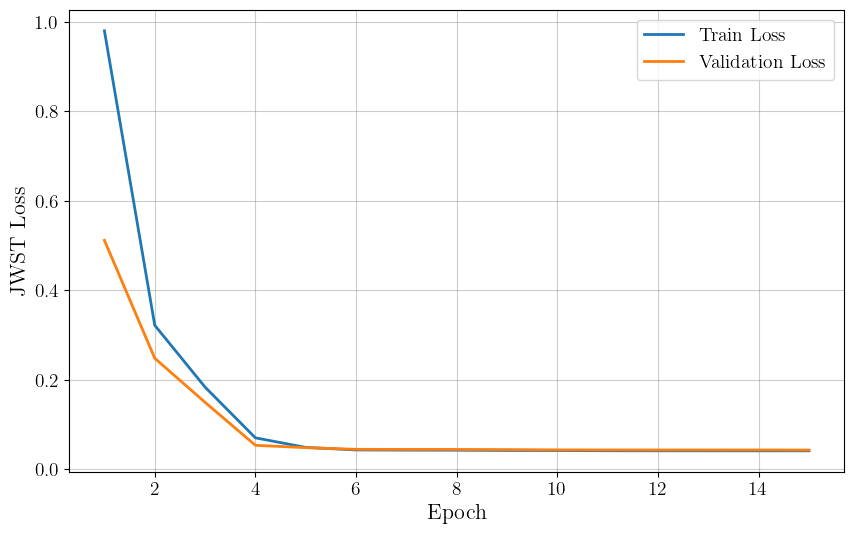

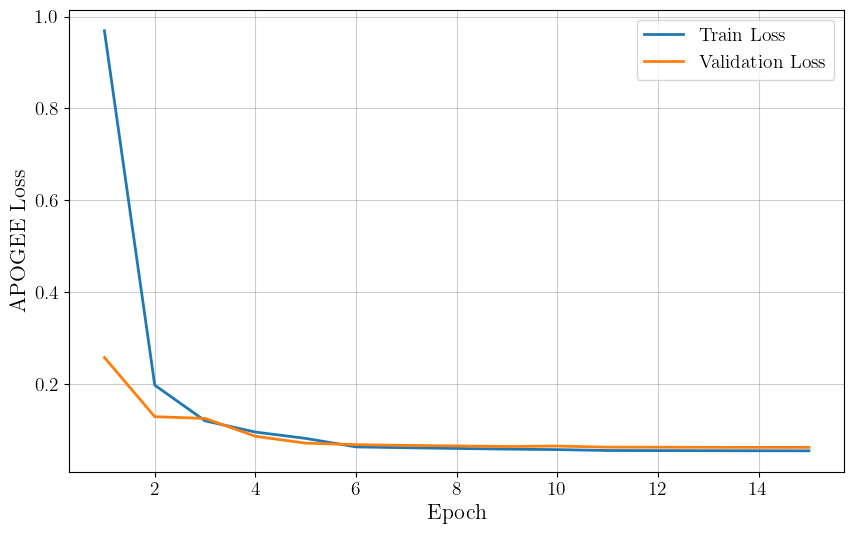

In [23]:
## Plot losses ## 
def plot_losses(train_losses, val_losses, model_name):
    """
    Plots training and validation losses over epochs. Save figure to "FIGURES" directory. 

    Args:
    - train_losses (list): contains training losses for each epoch.
    - val_losses (list): contains validation losses for each epoch.
    - model_name (str): 'APOGEE' or 'JWST'. 
    """
    plt.figure(figsize=(10, 6))  
    plt.plot(range(1, num_epochs + 1), train_losses, label = "Train Loss", linewidth=2)
    plt.plot(range(1, num_epochs + 1), val_losses, label = "Validation Loss", linewidth=2)
    plt.xlabel("Epoch", fontsize=16)
    plt.ylabel(f"{model_name} Loss", fontsize=16)
    plt.legend(fontsize=14)
    plt.xticks(fontsize=14)
    plt.yticks(fontsize=14) 
    
    # Save the figure
    plt.savefig(os.path.join("FIGURES", f"StarNet_{model_name}_loss_plot.png"))
    plt.show()
    plt.close()

plot_losses(train_j_losses, val_j_losses, "JWST")
plot_losses(train_a_losses, val_a_losses, "APOGEE")

In [24]:
## Save models ## 
def save_model(model, optimizer, model_name):
    """
    Save model and optimizer states to a specified file path.

    Parameters:
    - model (torch.nn.Module): PyTorch model to be saved.
    - optimizer (torch.optim.Optimizer): PyTorch optimizer to be saved.
    - model_name (str): 'APOGEE' or 'JWST'. 
    """
    torch.save({'optimizer' : optimizer.state_dict(),
                'model' : model.state_dict()}, 
               os.path.join("MODELS", f"StarNet_{model_name}.pth.tar"))
    print(f"Done.")
    
save_model(JWSTModel, JWSTOptimizer, "JWST") 
save_model(APOGEEModel, APOGEEOptimizer, "APOGEE") 

Done.
Done.


## **4. Build Mock Model** <a class="anchor" id="build-mock-model"></a>

In [25]:
## Define function to load model and optimizer states ## 
def load_model(model_name):
    """
    Load the state dictionary of the model and optimizer from the saved checkpoint.

    Parameters:
    - model_name (str): 'APOGEE' or 'JWST'. This is used to load the correct saved model.

    Returns:
    - model_state_dict: The state dict of the model.
    - optimizer_state_dict: The state dict of the optimizer.
    """
    checkpoint_path = os.path.join("MODELS", f"StarNet_{model_name}.pth.tar")
    checkpoint = torch.load(checkpoint_path)
    model_state_dict = checkpoint['model']
    optimizer_state_dict = checkpoint['optimizer']
    
    return model_state_dict, optimizer_state_dict

# Instantiate state dicts ## 
apogee_state_dict, apogee_optimizer_state_dict = load_model("APOGEE")
jwst_state_dict, jwst_optimizer_state_dict = load_model("JWST")

## Instantiate sample models ## 
torch.manual_seed(42)
sampleAPOGEEModel = StarNet(num_apogee_fluxes, num_filters, filter_length, pool_length, num_hidden, num_apogee_labels)
sampleJWSTModel = StarNet(num_jwst_fluxes, num_filters, filter_length, pool_length, num_hidden, num_jwst_labels)

## Load the state dicts into models ##
sampleAPOGEEModel.load_state_dict(apogee_state_dict)
sampleJWSTModel.load_state_dict(jwst_state_dict)

<All keys matched successfully>

In [26]:
## Freeze sampleAPOGEEModel parameters ##
for param in sampleAPOGEEModel.parameters():
    param.requires_grad = False 
    
## Freeze some sampleJWSTModel parameters ##
layers_to_freeze = ['fc2', 'output'] 
for name, param in sampleJWSTModel.named_parameters():
    if any(layer in name for layer in layers_to_freeze):
        param.requires_grad = False


## Check if frozen! ## 
for name, param in sampleAPOGEEModel.named_parameters():
    print(name, param.requires_grad)

for name, param in sampleJWSTModel.named_parameters():
    print(name, param.requires_grad)

conv1.weight False
conv1.bias False
conv2.weight False
conv2.bias False
fc1.weight False
fc1.bias False
fc2.weight False
fc2.bias False
output.weight False
output.bias False
conv1.weight True
conv1.bias True
conv2.weight True
conv2.bias True
fc1.weight True
fc1.bias True
fc2.weight False
fc2.bias False
output.weight False
output.bias False


## **5. Test Model** <a class="anchor" id="test-model"></a>

### **4.1. Get test predictions** <a class="anchor" id="get-test-preds"></a>

In [27]:
## Get denormalised predictions on test set ## 
def get_test_preds(model, test_dataloader):
    """
    Performs inference on test data and returns denormalized predictions. Requires the denormalize function, defined previously.

    Parameters:
    - model (torch.nn.Module): PyTorch model used for inference.
    - test_dataloader (torch.utils.data.DataLoader): DataLoader for the test set.

    Returns: 
    - test_preds (np.array): denormalized predictions. 
    """
    model.eval()
    test_preds = []
    with torch.inference_mode():
        for x_batch in test_dataloader:
            preds = model(x_batch[0].to(device).unsqueeze(1)).cpu().detach().numpy()
            test_preds.append(denormalize(scaler, preds)) 

    # Concatenate the list of numpy arrays
    return np.concatenate(test_preds)

test_j_preds = get_test_preds(JWSTModel, test_j_dataloader)
test_a_preds = get_test_preds(APOGEEModel, test_a_dataloader)

## Print shape of preds ## 
print(f"Shape of JWST test predictions is {test_j_preds.shape}") 
print(f"Shape of APOGEE test predictions is {test_a_preds.shape}")

Shape of JWST test predictions is (4751, 20)
Shape of APOGEE test predictions is (4751, 20)


### **4.2. Plot residuals** <a class="anchor" id="plot-residuals"></a>

In [28]:
## Get indices of JWST and APOGEE test sets (note: they are the same) ## 
test_indices = [np.where((jwst_labels_scaled.values == y_j_test[i]).all(axis=1))[0][0] for i in range(len(y_j_test))]

In [29]:
## Get residuals ## 
jwst_residuals = denormalize(scaler, y_j_test) - test_j_preds # alternatively, jwst_labels.iloc[test_j_indices] - test_j_preds
apogee_residuals = denormalize(scaler, y_a_test) - test_a_preds 

In [30]:
## Get SNR values ## 
z = np.array((noise_to_signal**(-1))[test_indices]) 

## Truncate SNR at ~90th percentile ## 
z[z > round(np.percentile(z, 90), -2)] = round(np.percentile(z, 90), -2) 

In [31]:
## Re-order SNR and residuals ## 
order = z.reshape(z.shape[0], ).argsort() 

z = z[order] 
jwst_true = denormalize(scaler, y_j_test)[order] 
apogee_true = denormalize(scaler, y_a_test)[order] 
jwst_residuals = jwst_residuals[order]
apogee_residuals = apogee_residuals[order]

## Sort indices according to SNR threshold ## 
indices_a = np.where(z >= round(np.percentile(z, 50), -2)) 
indices_b = np.where(z < round(np.percentile(z, 50), -2))n

## Print cut-offs ##
print(f"SNR 50th, 90th percentile: {round(np.percentile(z, 50), -2), round(np.percentile(z, 90), -2)}")

## Filter residuals based on SNR thresholds ## 
resid_j_a = jwst_residuals[indices_a,:]; resid_j_b = jwst_residuals[indices_b,:] 
resid_a_a = apogee_residuals[indices_a,:]; resid_a_b = apogee_residuals[indices_b,:]

SNR 50th, 90th percentile: (300.0, 700.0)


In [32]:
## Define bias and scatter ## 
bias_j = np.median(jwst_residuals, axis=0); bias_a = np.median(apogee_residuals, axis = 0)
scatter_j = np.std(jwst_residuals, axis=0); scatter_a = np.std(apogee_residuals, axis = 0)

/tmp/ipykernel_23786/4135275360.py:54: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


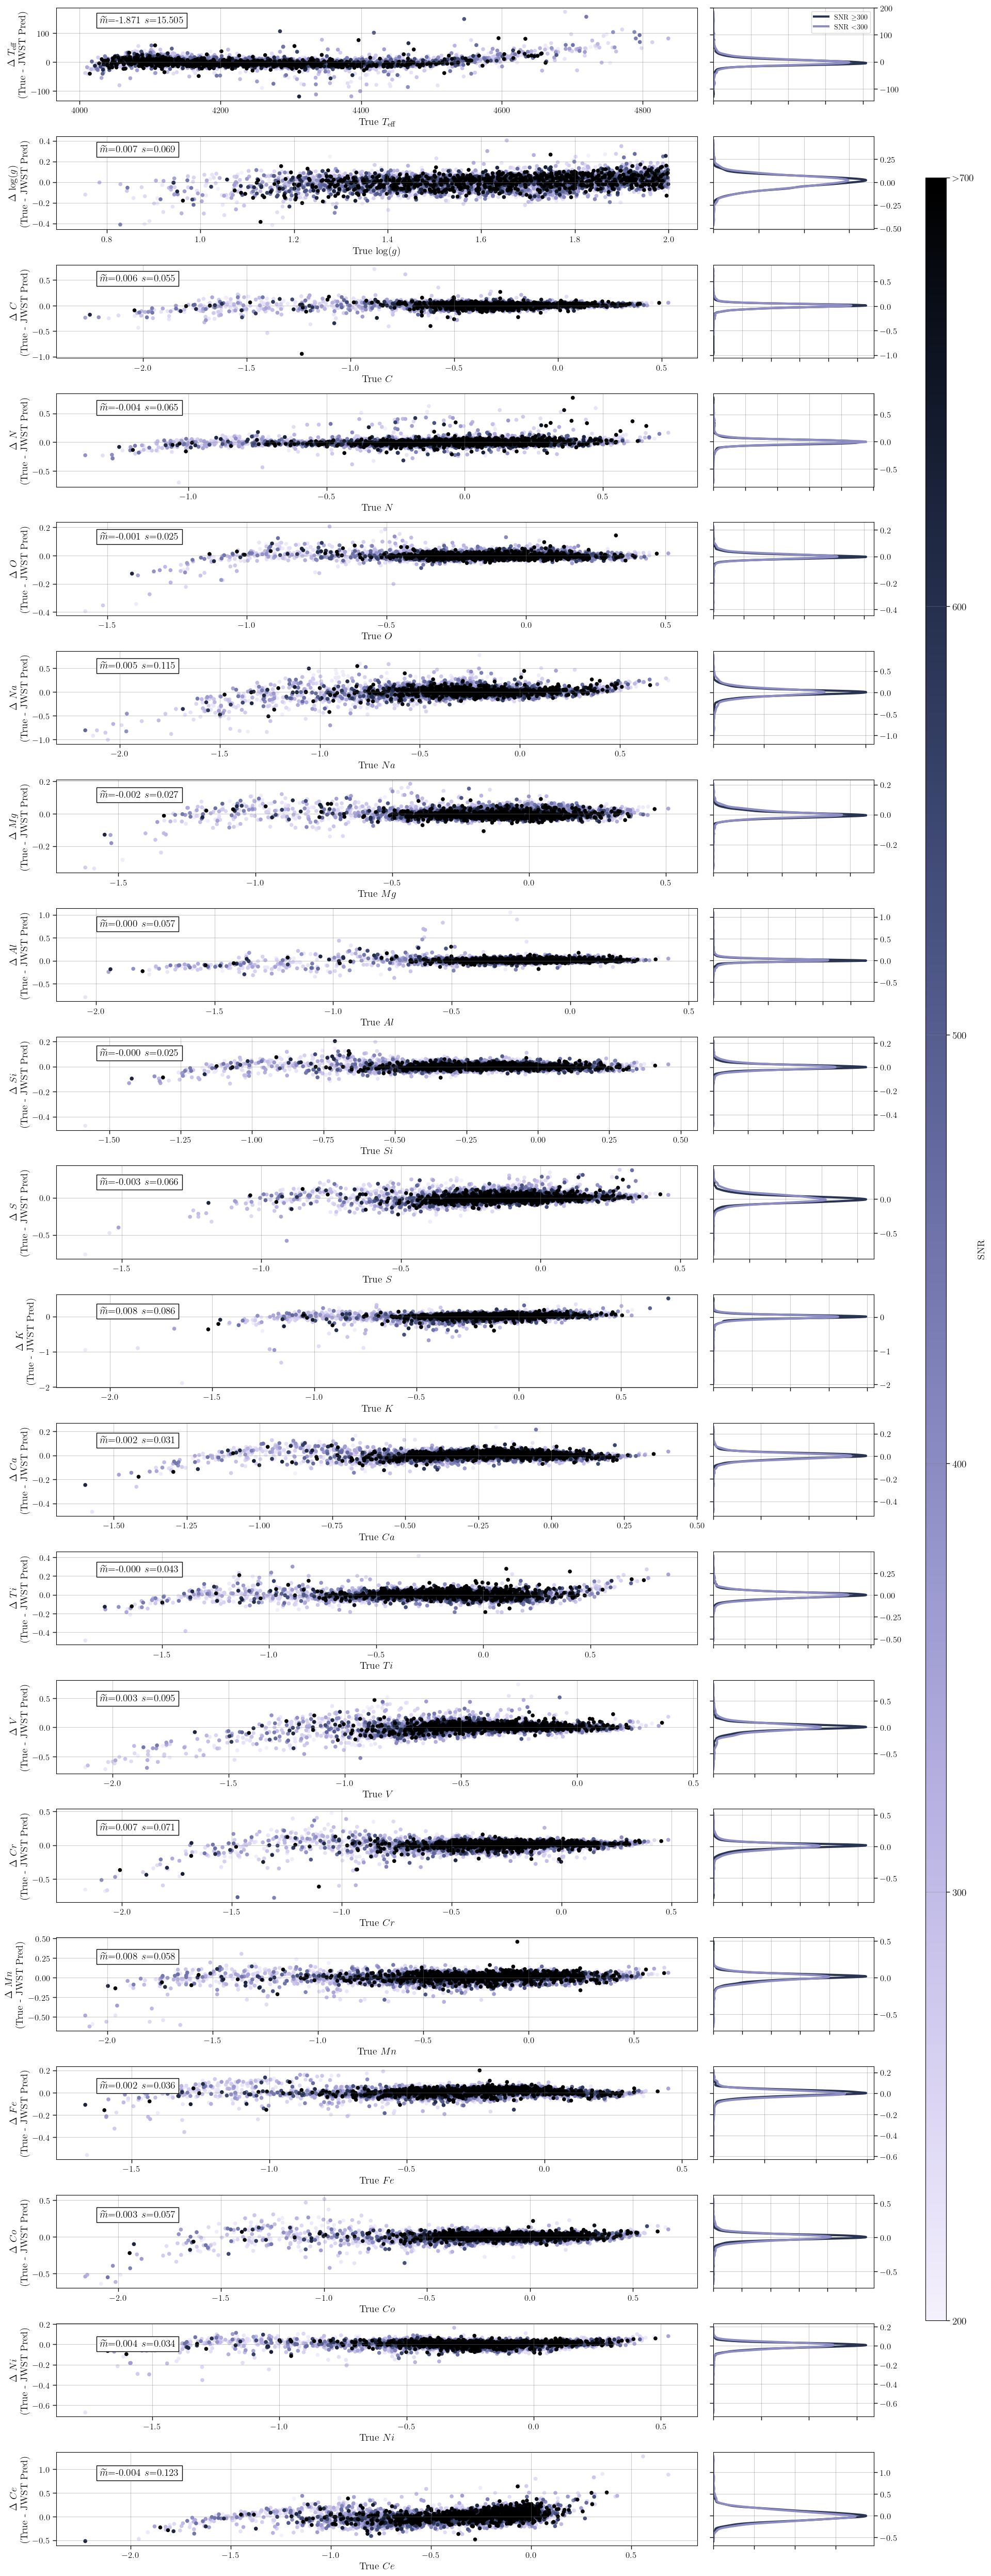

/tmp/ipykernel_23786/4135275360.py:54: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


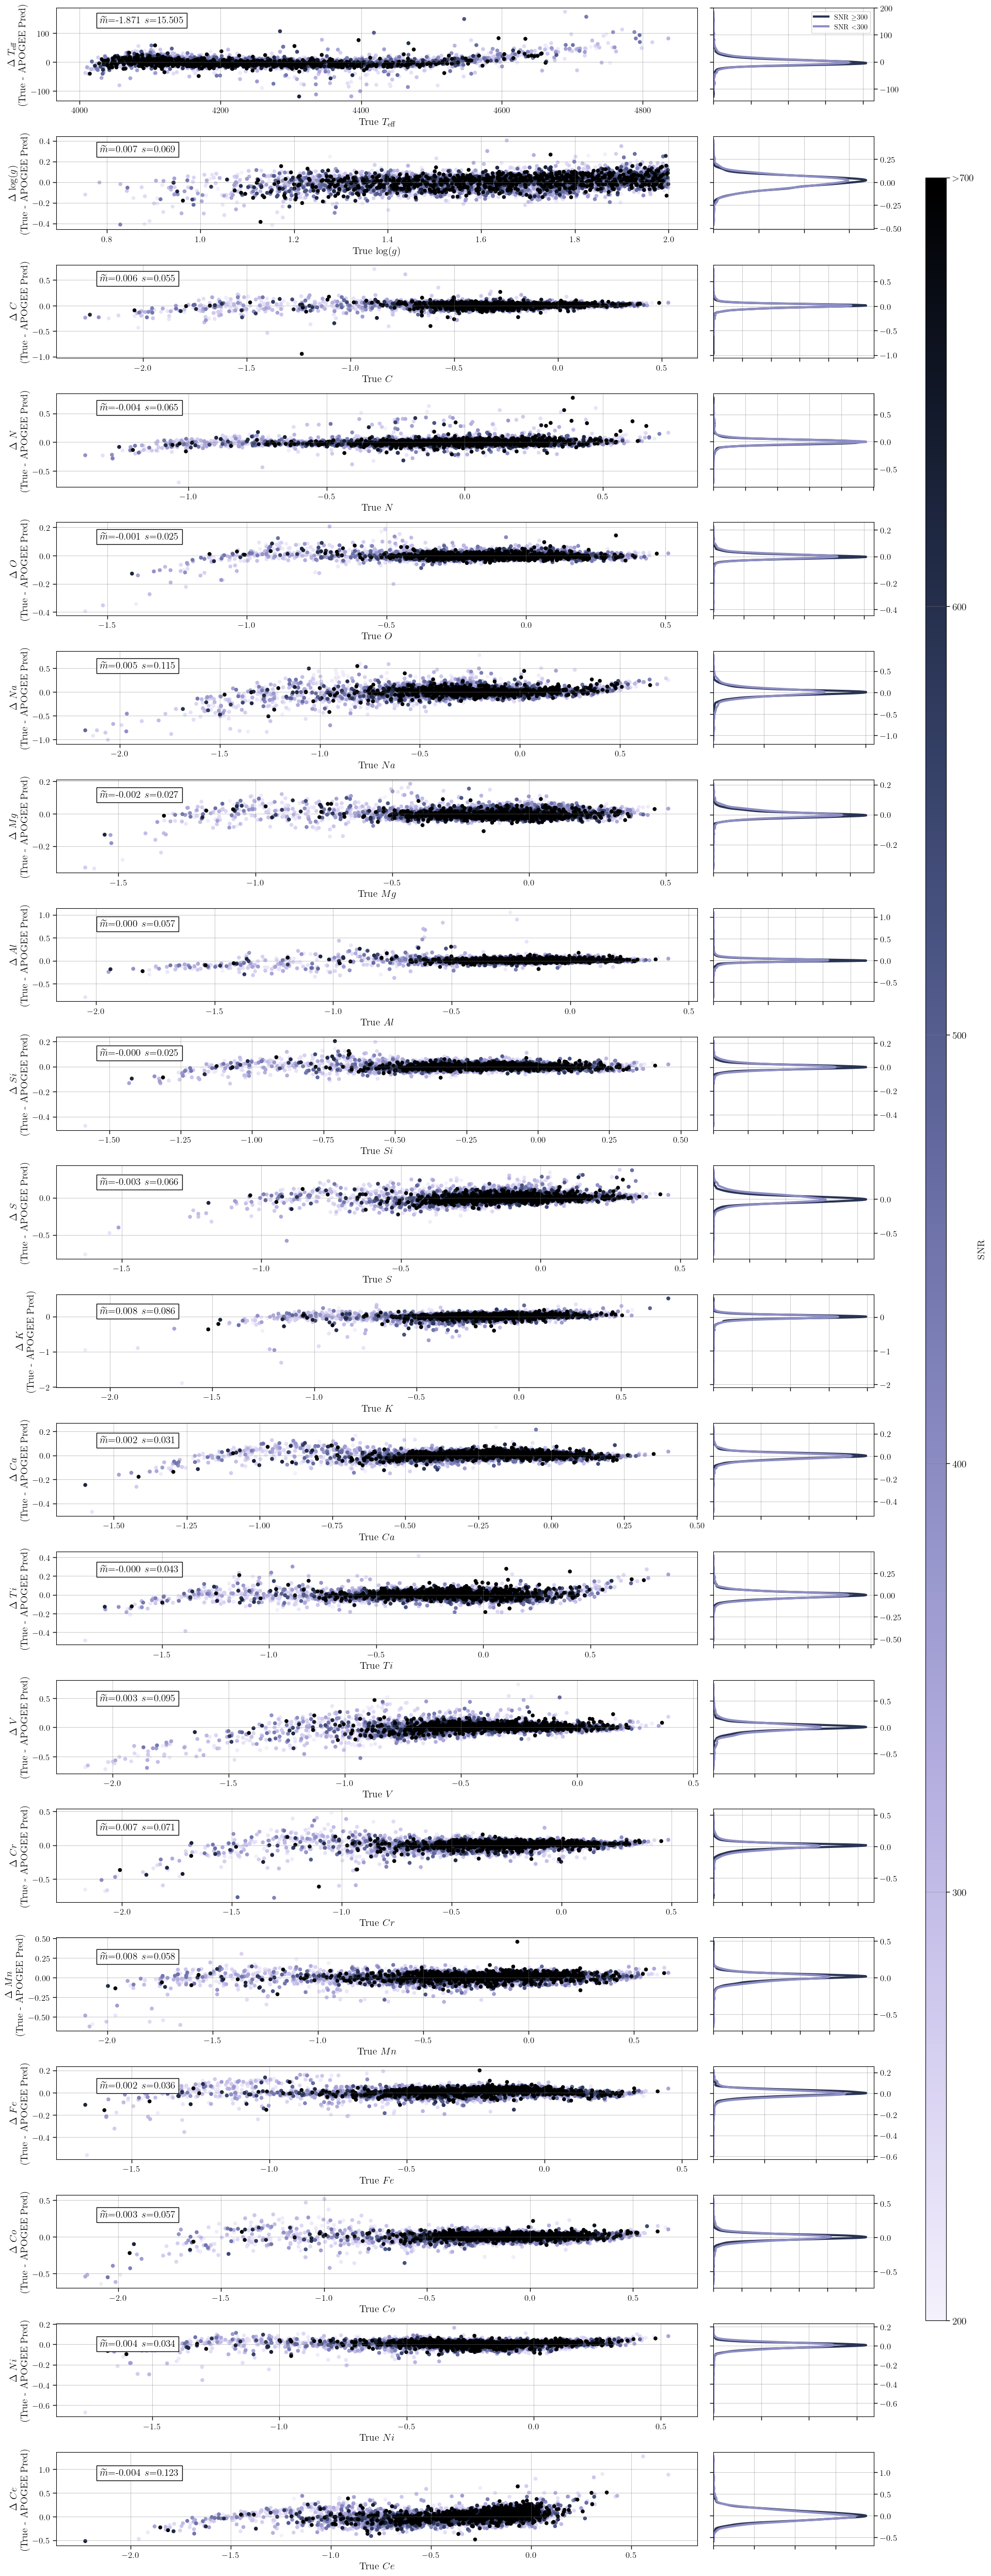

In [33]:
def plot_residuals(targets, residue, z, resid_a, resid_b, bias, scatter, model_name):
    """
    Plot residuals and their distributions for all labels.
    
    Parameters:
    - targets: Array of true target values.
    - residue: Array of residuals for each label.
    - z: Array of SNR values used for coloring the scatter plots.
    - resid_a: Residuals for SNR values above the threshold.
    - resid_b: Residuals for SNR values below the threshold.
    - bias: List of bias values for each label.
    - scatter: List of scatter values for each label.
    - model_name: 'APOGEE' or 'JWST'.  
    """
    
    num_labels = targets.shape[1]

    # Create a figure with subplots
    fig = plt.figure(figsize=(20, 50))
    gs = gridspec.GridSpec(20, 2, width_ratios=[4., 1.])

    for i in range(num_labels):
        # Scatter plot for residuals
        ax0 = plt.subplot(gs[i, 0])
        points = ax0.scatter(targets[:, i], residue[:, i], c=z, s=20, cmap=cmap)

        ax0.set_xlabel(f'True {label_names[i]}', fontsize=14)
        ax0.set_ylabel(rf'$\Delta$ {label_names[i]}' + f'\n(True - {model_name} Pred)', fontsize=14)
        ax0.tick_params(labelsize=12, width=1, length=5)

        # KDE plot for residual distributions
        ax1 = plt.subplot(gs[i, 1])
        sns.kdeplot(y=resid_a[0, :, i], color=cmap(200), lw=3, ax=ax1, label='SNR $\geq$300')
        sns.kdeplot(y=resid_b[0, :, i], color=cmap(100), lw=3, ax=ax1, label='SNR $<$300')
        if i == 0:
            plt.legend()

        ax1.tick_params(right=True, labelleft=False, labelright=True, labelbottom=False, labelsize=12, width=1, length=5)
        ax1.set_xlabel('')

        # Display bias and scatter values
        bbox_props = dict(boxstyle="square,pad=0.3", fc="w", ec="k", lw=1)
        plt.figtext(0.1, 0.99 - (i*0.05),
                    rf'$\widetilde{{m}}$={bias[i]:.3f}  $s$={scatter[i]:.3f}',
                    size=14, bbox=bbox_props)

    # Add colorbar
    cbar_ax = fig.add_axes([0.9, 0.1, 0.02, 0.83])
    cbar = fig.colorbar(points, cax=cbar_ax)
    cbar.set_label('SNR', size=14)
    cbar.ax.tick_params(labelsize=14, width=1, length=5)
    cbar.set_ticks([200, 300, 400, 500, 600, 700])
    cbar.set_ticklabels(['200', '300', '400', '500', '600', '$>$700'])
    plt.tight_layout()
    fig.subplots_adjust(right=0.85)

    plt.savefig(os.path.join("FIGURES", f"STARNet_{model_name}_residual_plots.png"))
    plt.show()

plot_residuals(jwst_true, jwst_residuals, z, resid_j_a, resid_j_b, bias_j, scatter_j, "JWST")
plot_residuals(apogee_true, jwst_residuals, z, resid_j_a, resid_j_b, bias_j, scatter_j, "APOGEE")

### **4.3. Get metrics** <a class="anchor" id="get-metrics"></a>

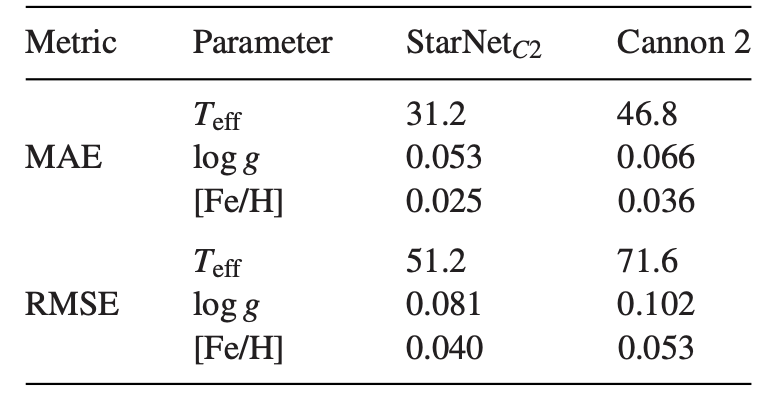 

In [34]:
def get_metrics(targets, test_preds, model_name):
    """
    Calculate evaluation metrics for each label in a set of predictions.

    Parameters:
    - targets (np.array): true target values.
    - test_preds (np.array): predicted test values.
    - model_name (str): 'APOGEE' or 'JWST'. 

    Returns:
    - DataFrame containing MAE, MSE, RMSE for each label, rounded to 3 decimal places. 
    """

    MAE = []
    MSE = []
    RMSE = [] 

    targets = pd.DataFrame(targets) 
    test_preds = pd.DataFrame(test_preds)

    for i in range(test_preds.shape[1]):
        MAE.append(mean_absolute_error(targets[i], test_preds[i]))
        MSE.append(mean_squared_error(targets[i], test_preds[i]))
        RMSE.append(np.sqrt(mean_squared_error(targets[i], test_preds[i]))) 

    metrics = pd.DataFrame({
        f'{model_name} Labels': label_names,
        'MAE': MAE,
        'MSE': MSE,
        'RMSE': RMSE
    }).round(3)

    return metrics 

get_metrics(jwst_true, test_j_preds, "JWST")

JWST Labels      MAE        MSE     RMSE
0   $T_{\mathrm{eff}}$  161.513  41426.648  203.535
1            $\log(g)$    0.262      0.108    0.329
2                  $C$    0.393      0.283    0.532
3                  $N$    0.346      0.199    0.446
4                  $O$    0.284      0.139    0.373
5                 $Na$    0.386      0.256    0.506
6                 $Mg$    0.289      0.148    0.385
7                 $Al$    0.301      0.177    0.421
8                 $Si$    0.281      0.135    0.368
9                  $S$    0.249      0.106    0.326
10                 $K$    0.303      0.160    0.400
11                $Ca$    0.281      0.135    0.367
12                $Ti$    0.378      0.244    0.494
13                 $V$    0.342      0.196    0.443
14                $Cr$    0.370      0.239    0.488
15                $Mn$    0.442      0.332    0.576
16                $Fe$    0.343      0.200    0.447
17                $Co$    0.372      0.252    0.502
18                $Ni$    0.337      0.199    0.446
19                $Ce$    0.376      0.238    0.488

In [35]:
get_metrics(apogee_true, test_a_preds, "APOGEE")

APOGEE Labels      MAE        MSE     RMSE
0   $T_{\mathrm{eff}}$  160.334  40968.897  202.408
1            $\log(g)$    0.259      0.106    0.325
2                  $C$    0.389      0.278    0.528
3                  $N$    0.346      0.198    0.445
4                  $O$    0.280      0.135    0.368
5                 $Na$    0.385      0.254    0.504
6                 $Mg$    0.284      0.144    0.380
7                 $Al$    0.296      0.174    0.417
8                 $Si$    0.278      0.133    0.364
9                  $S$    0.247      0.104    0.323
10                 $K$    0.299      0.155    0.394
11                $Ca$    0.279      0.133    0.364
12                $Ti$    0.375      0.241    0.491
13                 $V$    0.338      0.193    0.439
14                $Cr$    0.369      0.238    0.487
15                $Mn$    0.442      0.332    0.576
16                $Fe$    0.343      0.199    0.446
17                $Co$    0.371      0.250    0.500
18                $Ni$    0.335      0.197    0.443
19                $Ce$    0.376      0.237    0.487

## **5. Appendix** <a class="anchor" id="appendix"></a>
OLD VERSIONS OF NOTEBOOK AVAILABLE IN `/SCRATCH/OLD_NOTEBOOKS`:
- `JWSTNet.ipynb`
- `APOGEENet.ipynb` 

## **6. References** <a class="anchor" id="refs"></a>
**Literature** 
Fabbro, S., “An application of deep learning in the analysis of stellar spectra”, <i>Monthly Notices of the Royal Astronomical Society</i>, vol. 475, no. 3, OUP, pp. 2978–2993, 2018. doi:10.1093/mnras/stx3298.

**Code** 
https://github.com/astroai/starnet/blob/master/4_Train_Model_pytorch.ipynb 